# VIX strategies #

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import io
import os
import tradingWithPython as twp
from tradingWithPython import sharpe # general trading toolbox functions
from tradingWithPython import cboe_ckc as ckc
import pandas as pd # pandas time series library
from datetime import datetime
import quandl
quandl.ApiConfig.api_key = 'wxychbrgu7o7x3MRq4Hx'

C:\Users\chekitsch\Anaconda3\lib\site-packages\tradingWithPython\lib\cboe.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [122]:
# read CSV from local drive
path1 = r'C:\Users\chekitsch\Documents\Trading\Historical data\VIX\vix_etf.csv'
etf = pd.read_csv(path1, index_col=0, header = 0, parse_dates=True)

path2 = r'C:\Users\chekitsch\Documents\Trading\Historical data\VIX\term_structure.csv'
vixfut = pd.read_csv(path2, index_col=0, header = 0, parse_dates=True)

In [121]:
existDate

Timestamp('2017-05-12 00:00:00')

In [11]:
# update SVXY and UVXY prices
try:
    existDate = etf.index[-1]
    sDate = existDate + pd.tseries.offsets.Day(weekday=1)   # shift forward existDate by 1 week day
    svxy = quandl.get('EOD/SVXY', start_date=sDate.date().isoformat())
    uvxy = quandl.get('EOD/UVXY', start_date=sDate.date().isoformat())
    tqqq = quandl.get('EOD/TQQQ', start_date=sDate.date().isoformat())

    if len(svxy) > 0:
        etfprice = [[]for i in range(4)]
        for i in range(len(svxy)):
            etfprice[0].append(svxy.index[i])
            etfprice[1].append(svxy.Adj_Close[i])
            etfprice[2].append(uvxy.Adj_Close[i])
            etfprice[3].append(tqqq.Adj_Close[i])

        d = dict(list(zip(list(etf), etfprice[1:])))
        df = pd.DataFrame(d, index = pd.Index(etfprice[0]))
        etf = etf.append(df)
        etf.to_csv(path1)
except Exception as e:
    print (e)

In [12]:
# update VIX futures prices
vixfut = ckc.updateVixData(path2, vixfut)

len(etf), len(vixfut)

VIX futures data is up to date as of  2017-05-12


(3306, 3307)

In [123]:
# conform vixfut to etf.index
vixfut = vixfut.reindex(etf.index)

len(etf), len(vixfut)

(3306, 3306)

In [124]:
# enrich VIX data
ratio_v_v1 = vixfut.VIX / vixfut.UX1
ratio_v1_v2 = vixfut.UX1 / vixfut.UX2
vixfut['ratio_contango'] = (0.7 * ratio_v_v1 + 0.3 * ratio_v1_v2) - 1
vixfut['ratio_vv'] = vixfut['VIX'] / vixfut['VXV']
vixfut['ratio_pct_chg'] = vixfut.VIX.pct_change()


In [125]:
# calculate 30 day VIX
vixfut['expiry'] = 0
vixfut['VIX_30day'] = 0
for i, d in enumerate(vixfut.index):
    vixfut.loc[vixfut.index[i],'expiry'] = ckc.vixExpiration(d.year, d.month)
    v1 = (vixfut.expiry[i] - vixfut.index[i]).days * vixfut.UX1[i]
    v2 = (30 - (vixfut.expiry[i] - vixfut.index[i]).days) * vixfut.UX2[i]
    vixfut.loc[vixfut.index[i],'VIX_30day'] = (1/30) * (v1 + v2)

# VIX 250-day moving average
vixfut['vix250ma'] = vixfut['VIX'].rolling(window=250).mean()
vixfut['vix250stdev'] = vixfut['VIX'].rolling(window=250).std()
vixfut['z_score'] = (vixfut['VIX'] - vixfut['vix250ma']) / vixfut['vix250stdev']

              VIX  VIX_30day  vix250ma  vix250stdev   z_score  ContangoAvg
2017-05-01  10.11  12.198333  13.57004     2.489746 -1.389716     0.118644
2017-05-02  10.59  12.325000  13.54820     2.491851 -1.187150     0.100593
2017-05-03  10.68  12.555000  13.52728     2.493896 -1.141699     0.102576
2017-05-04  10.46  12.263333  13.51024     2.500260 -1.219969     0.100980
2017-05-05  10.57  12.315000  13.49424     2.506242 -1.166783     0.095218
2017-05-08   9.77  12.160000  13.47880     2.517268 -1.473343     0.130650
2017-05-09   9.96  12.195000  13.45988     2.525889 -1.385603     0.119496
2017-05-10  10.21  12.253333  13.44308     2.533500 -1.276132     0.105612
2017-05-11  10.60  12.385000  13.42532     2.537819 -1.113286     0.091432
2017-05-12  10.40  12.225000  13.40820     2.543751 -1.182584     0.093116


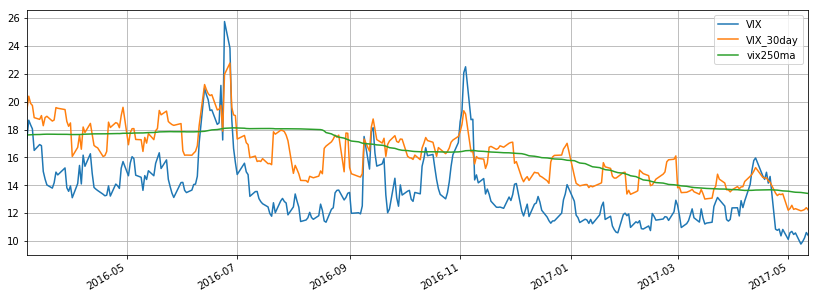

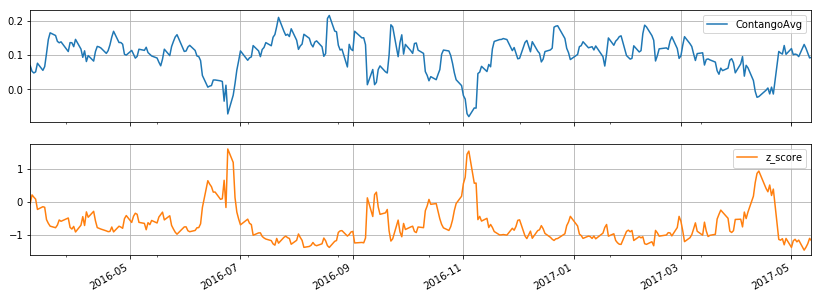

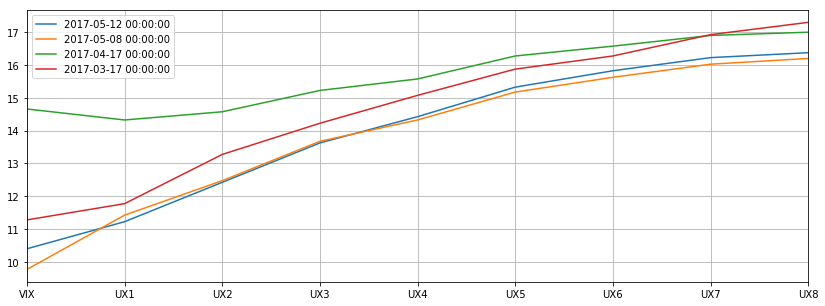

In [9]:
lookback = -300
figsize(14,5)
vixfut[['VIX','VIX_30day','vix250ma']][lookback:].plot(grid=True)
vixfut[['ratio_contango','z_score']][lookback:].plot(subplots=True,grid=True)

print (vixfut[['VIX','VIX_30day','vix250ma','vix250stdev','z_score','ratio_contango']][-10:])


days_ago = [-1,-5,-20,-40]

figure()
for i, d in enumerate(days_ago):
    vixfut.iloc[d,:9].plot(legend=True, grid=True)


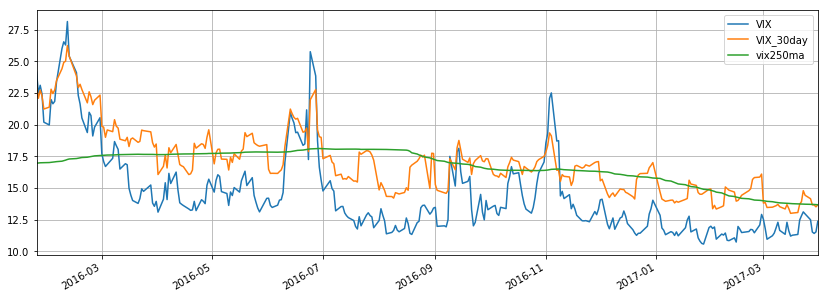

In [10]:
vixfut[['VIX','VIX_30day','vix250ma']][lookback:].plot(grid=True)
plt.savefig(os.path.abspath('pics\\vix_chart') + '.png', format = 'png')

In [26]:

mypath = os.path.abspath('vix_chart') + '.png'
mypath + '.png'

'C:\\Users\\chekitsch\\Documents\\Python\\Research\\vix_chart.png'

In [45]:
mymail = twp.email.Bimail('VIX analytics ' +datetime.now().strftime('%Y/%m/%d'), ['bard.ckchan@gmail.com', 'windflower17@hotmail.com'])
mymail.htmladd('Put text here')
mymail.htmladd('VIX statistics')
mymail.htmladd(((vixfut[['VIX','VIX_30day','vix250ma','vix250stdev','z_score','ContangoAvg']][-10:]).to_html()))
mymail.htmladd('<img src="cid:pics/vix_chart.png"/>') 
mymail.addattach(['pics/vix_chart.png'])
mymail.htmladd('<img src="cid:pics/vix_chart.png"/>') 
mymail.addattach(['pics/vix_chart.png'])


In [41]:
mymail.send()

NameError: name 'mymail' is not defined

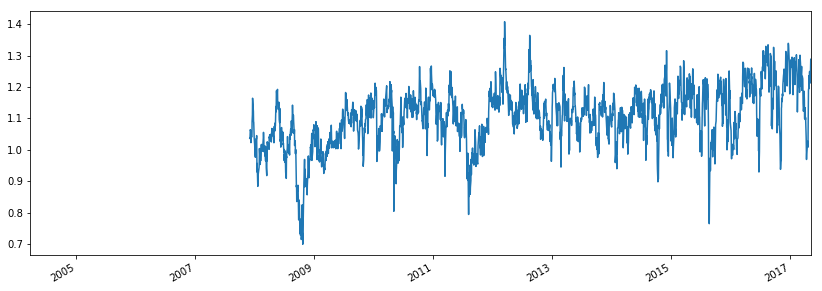

In [22]:
vixfut['R2'].plot()

## 1. trade signals based on VIX futures term structure i.e. contango ##
employing SVXY and UVXY

In [138]:
pos = pd.DataFrame(index = vixfut.index) # initiate position dataframe
pos['SVXY'] = 0
pos['UVXY'] = 0
pos['TQQQ'] = 0

thresh = -0.06 # long SVXY if contango > x%

#pos['SVXY'][(vixfut['ratio_contango'] < -0.046) | (vixfut['ratio_vv'] <= 0.8) | (vixfut['ratio_pct_chg'] <= -0.1)] = 1
#pos['UVXY'][((vixfut['ratio_contango'] > 0.055) | (vixfut['ratio_vv'] >= 1.0) | (vixfut['ratio_pct_chg'] >= 0.1)) & (pos['SVXY'] != 1)] = 1
pos['SVXY'][(vixfut['ratio_contango'] < -0.046) | (vixfut['ratio_vv'] <= 0.8) | (vixfut['ratio_pct_chg'] <= -0.1) | (vixfut.VIX > 19.8)] = 1
pos['UVXY'][((vixfut['ratio_contango'] > 0.055) | (vixfut['ratio_vv'] >= 1.0) | (vixfut['ratio_pct_chg'] >= 0.1) | (vixfut.VIX < 14.1)) & (pos['SVXY'] != 1)] = 1
pos['TQQQ'][(pos['UVXY'] == 0) & (pos['SVXY'] == 0)] = 1

#pos = pos.shift(1)  # shift signal forward ---> EOD signal is acted upon the next day

R = etf.pct_change()
R = R.shift(-1)

Invested in SVXY 2440 out of 3306 days
Invested in UVXY 444 out of 3306 days
Invested in TQQQ 422 out of 3306 days


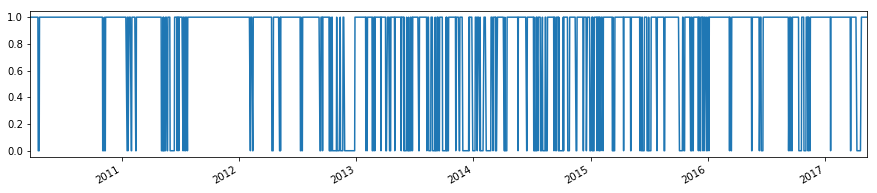

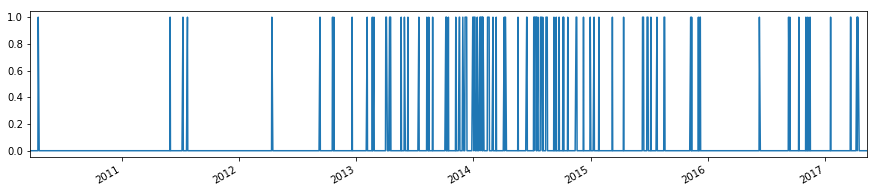

In [139]:
print ("Invested in SVXY {0} out of {1} days".format(len(pos[pos.SVXY>0]), len(pos)))
print ("Invested in UVXY {0} out of {1} days".format(len(pos[pos.UVXY>0]), len(pos)))
print ("Invested in TQQQ {0} out of {1} days".format(len(pos[pos.TQQQ>0]), len(pos)))

figsize(15,3)
pos.SVXY.tail(1800).plot()
figure()
pos.UVXY.tail(1800).plot()

In [140]:
pnl = pd.DataFrame(index = pos.index) # initiate pnl dataframe
pnl['SVXY_BH'] = (R.SVXY) # SVXY buy and hold
pnl['SVXY'] = (R.SVXY * pos.SVXY)
pnl['UVXY'] = (R.UVXY * pos.UVXY)
pnl['TQQQ'] = (R.TQQQ * pos.TQQQ)
pnl['Hybrid'] = pnl.SVXY + pnl.UVXY

pnl = pnl[0:3500]

Sharpe: 
 SVXY_BH    0.802004
SVXY       0.797387
UVXY      -0.009536
TQQQ       0.915630
Hybrid     0.630115
dtype: float64


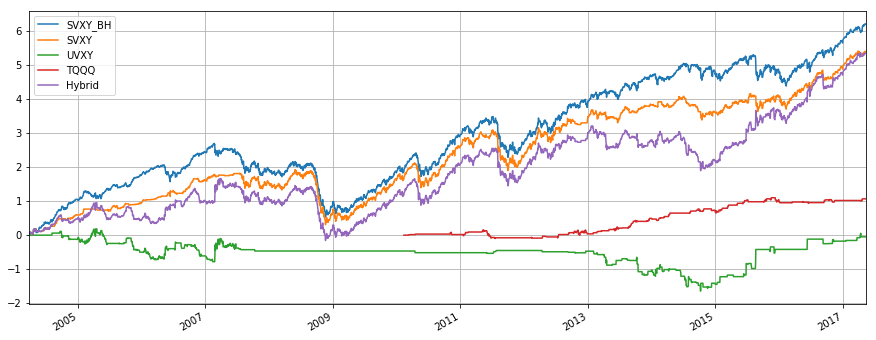

In [141]:
figsize(15,6)
pnl.tail(3500).cumsum().plot(grid=True)
#(pnl+1).cumprod().plot(grid=True)

print('Sharpe: \n', twp.sharpe(pnl))

## Rewrite code above in function form: ##

In [15]:
def vixEtfStrategy(etfPrice, vixfut, threshold=0.00):
    pos = pd.DataFrame(index = vixfut.index) # initiate position dataframe
    pos['SVXY'] = 0
    pos['UVXY'] = 0

    pos['SVXY'][vixfut['ContangoAvg'] >= threshold] = 1  # long SVXY if contango >= threshold
    pos['UVXY'][vixfut['ContangoAvg'] < threshold] = 1  # long UVXY if contango < threshold
    #pos = pos.shift(1)  # shift signal forward ---> EOD signal is acted upon the next day
    print (" SVXY {0} days, UVXY {1} days out of {2} days".format(len(pos[pos.SVXY>0]), len(pos[pos.UVXY>0]), len(pos)))
    
    R = etfPrice.pct_change()
    R = R.shift(-1)
    
    pnl = pd.DataFrame(index = pos.index) # initiate pnl dataframe
    pnl['SVXY_BH'] = (R.SVXY) # SVXY buy and hold
    pnl['SVXY'] = (R.SVXY * pos.SVXY) # leverage up SVXY to match UVXY
    pnl['UVXY'] = (R.UVXY * pos.UVXY)
    pnl['SVXY+UVXY'] = pnl.SVXY + pnl.UVXY

    return pnl

In [16]:
pnl = vixEtfStrategy(etf, vixfut, -0.06)

 SVXY 3050 days, UVXY 126 days out of 3306 days


Sharpe: 
 SVXY_BH      0.802004
SVXY         1.080904
UVXY         0.566246
SVXY+UVXY    1.202839
dtype: float64


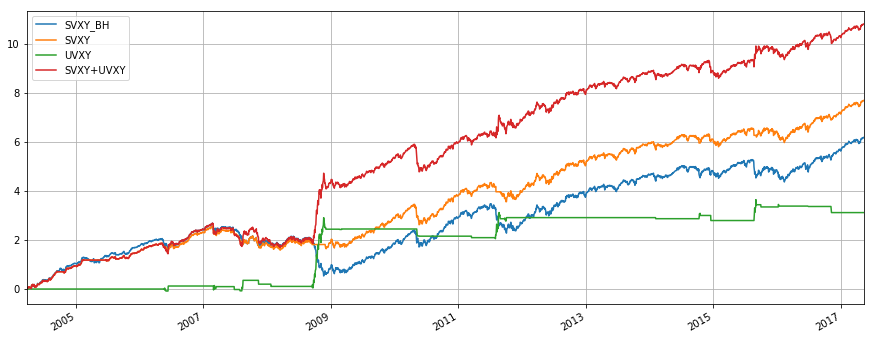

In [18]:
figsize(15,6)
pnl_zoom = pnl[:]  # select period for calculation
pnl_zoom.cumsum().plot(grid=True)
#(1+pnl_zoom).cumprod().plot(grid=True)

print('Sharpe: \n', twp.sharpe(pnl_zoom))

## Parameter Scan ##

To test strategy performance out-of-sample we will first divide the dataset in two parts:

* train : data to develop and optimize strategy on
* test : out-of-sample data, only for testing

In [204]:
etf_train = etf[:-500]  # all data except last 500 days
vixfut_train = vixfut[:-500]

threshold = arange(-0.10, 0.06, 0.005) # from -8% to 5% in steps of 0.5%

SH = np.zeros(len(threshold))

from tradingWithPython.lib.extra import ProgressBar
pBar = ProgressBar(len(threshold)-1)

for i, f in enumerate(threshold):
    pBar.animate(i)
    pnl = vixEtfStrategy(etf_train, vixfut_train, f)
    SH[i] = (twp.sharpe(pnl))[3]

 [                       0%                       ] SVXY 2571 days, UVXY 56 days out of 2757 days
 [*                      3%                       ]  1 of 31 complete SVXY 2568 days, UVXY 59 days out of 2757 days
 [***                    6%                       ]  2 of 31 complete SVXY 2563 days, UVXY 64 days out of 2757 days
 [*****                 10%                       ]  3 of 31 complete SVXY 2556 days, UVXY 71 days out of 2757 days
 [******                13%                       ]  4 of 31 complete SVXY 2550 days, UVXY 77 days out of 2757 days
 [********              16%                       ]  5 of 31 complete SVXY 2544 days, UVXY 83 days out of 2757 days
 [*********             19%                       ]  6 of 31 complete SVXY 2538 days, UVXY 89 days out of 2757 days
 [***********           23%                       ]  7 of 31 complete SVXY 2532 days, UVXY 95 days out of 2757 days
 [************          26%                       ]  8 of 31 complete SVXY 2516 days, UVXY

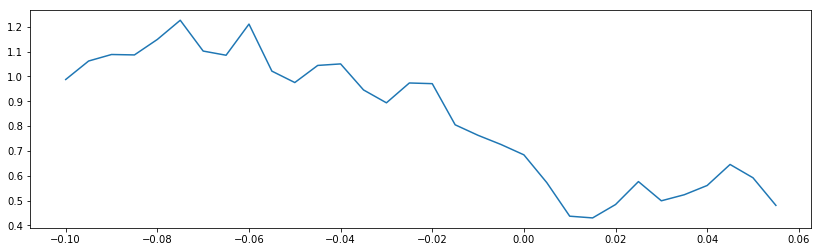

In [208]:
figsize(14,4)
plot(threshold, SH)


## Out of sample test

In [149]:
df = pd.DataFrame(index = etf.index)
df['full'] = (vixEtfStrategy(etf, vixfut, -0.06))['SVXY+UVXY']
df['train'] = (vixEtfStrategy(etf_train, vixfut_train, -0.06))['SVXY+UVXY']


 SVXY 3001 days, UVXY 126 days out of 3257 days
 SVXY 2516 days, UVXY 111 days out of 2757 days


Sharpe: 
 full     0.874877
train    0.271423
dtype: float64


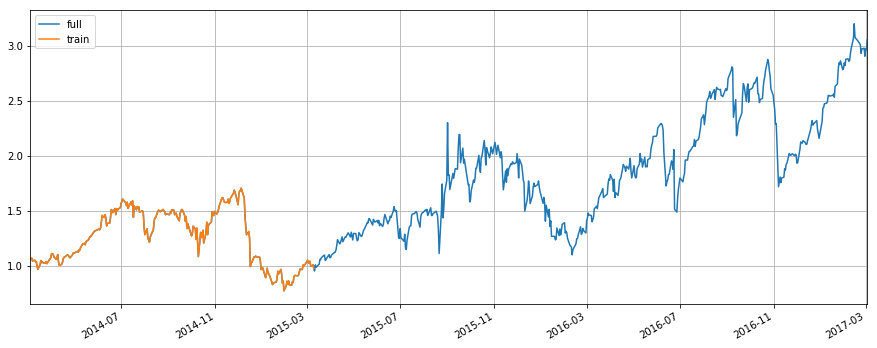

In [163]:
df_zoom = df[2500:]  # select period for calculation
#df_zoom.cumsum().plot(grid=True)
(1+df_zoom).cumprod().plot(grid=True)

print('Sharpe: \n', twp.sharpe(df_zoom))

In [ ]:
pnl